In [9]:
%config Completer.use_jedi = False
%matplotlib notebook
import astropy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.table import Table
from astropy.io import fits
from glob import glob
import os
from tqdm import tqdm_notebook, tnrange, tqdm
#import pandas as pd
from astropy.wcs import WCS
import sys
from spectral_cube import SpectralCube
import fs
import fs.copy

ModuleNotFoundError: No module named 'fs'

In [19]:
#rootdir = '/group/askap/mcc381/RACS/'
#sbid = '8585/'
#field = 'RACS_test4_1.05_1049-31A/'

rootdir= '/priv/myrtle2/possum/thomson/cubes/'
sbid = ''
field = ''

cubes = glob(rootdir+sbid+field+'image.restored.*contcube*linmos*fits')
images = glob(rootdir+sbid+field+'image.restored.i*contcube*linmos*fits')
selavyfits = glob(rootdir+sbid+field+'selavy*/*.fits')
votab = glob(rootdir+sbid+field+'selavy*/*island*.xml')

islands = Table.read(votab[0], format='votable')

In [6]:
cubes

['/priv/myrtle2/possum/thomson/cubes/image.restored.i.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits']

In [17]:
images

['/priv/myrtle2/possum/thomson/cubes/image.restored.i.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits']

In [20]:
selavyfits

['/priv/myrtle2/possum/thomson/cubes/selavy/componentMap_image.i.SB8583.cont.RACS_test4_1.05_1049-31A.linmos.taylor.0.restored.fits']

In [21]:
i_taylor = SpectralCube.read(selavyfits[0], mode='denywrite')
wcs_taylor = WCS(i_taylor.header)
i_cube = SpectralCube.read(cubes[0], mode='denywrite')
wcs_cube = WCS(i_cube.header)
#q_cube = SpectralCube.read(cubes[0], mode='denywrite')
#u_cube = SpectralCube.read(cubes[1], mode='denywrite')

In [22]:
ra_min, dec_min, freq = wcs_taylor.all_pix2world(islands['col_x_min'], islands['col_y_min'], 0, 0)
ra_max, dec_max, freq = wcs_taylor.all_pix2world(islands['col_x_max'], islands['col_y_max'], 0, 0)

x_min, y_min, _ = np.array(wcs_cube.all_world2pix(ra_min, dec_min, freq, 0)).astype(int)
x_max, y_max, _ = np.array(wcs_cube.all_world2pix(ra_max, dec_max, freq, 0)).astype(int)
dy, dx = y_max - y_min, x_max-x_min

In [23]:
source_dict = {}
for name in islands.colnames:
    newname = name.replace('col_', '')
    source_dict[newname] = []
    

In [24]:
i_cutouts = []
#q_cutouts = []
#u_cutouts = []
for name in islands.colnames:
    source_dict[name.replace('col_', '')].append(islands[name][0])
pad = 0
for i in tnrange(len(islands)):
    if y_max[i]>i_cube.shape[2] or x_max[i]>i_cube.shape[2] or x_min[i]<0 or y_min[i]<0:
        continue
    elif int(y_min[i]-pad*dy[i]) > 0 and int(x_min[i]-pad*dx[i]) > 0 and \
        int(y_max[i]+pad*dy[i]) < i_cube.shape[2] and int(x_max[i]+pad*dx[i]) < i_cube.shape[2]:
        i_cutout = i_cube[:,int(y_min[i]-pad*dy[i]):int(y_max[i]+pad*dy[i]), \
                             int(x_min[i]-pad*dx[i]):int(x_max[i]+pad*dx[i])]
        #q_cutout = q_cube[:,int(y_min[i]-pad*dy[i]):int(y_max[i]+pad*dy[i]), \
        #                     int(x_min[i]-pad*dx[i]):int(x_max[i]+pad*dx[i])]
        #u_cutout = u_cube[:,int(y_min[i]-pad*dy[i]):int(y_max[i]+pad*dy[i]), \
        #                     int(x_min[i]-pad*dx[i]):int(x_max[i]+pad*dx[i])]
        i_cutouts.append(i_cutout)
        #q_cutouts.append(q_cutout)
        #u_cutouts.append(u_cutout)
        for name in islands.colnames:
            source_dict[name.replace('col_', '')].append(islands[name][i])
    else:
        i_cutout = i_cube[:,y_min[i]:y_max[i], x_min[i]:x_max[i]]
        #q_cutout = q_cube[:,y_min[i]:y_max[i], x_min[i]:x_max[i]]
        #u_cutout = u_cube[:,y_min[i]:y_max[i], x_min[i]:x_max[i]]
        i_cutouts.append(i_cutout)
        #q_cutouts.append(q_cutout)
        #u_cutouts.append(u_cutout)
        for name in islands.colnames:
            source_dict[name.replace('col_', '')].append(islands[name][i])

In [29]:
i_cutouts[1].hdulist

In [29]:
sizes_bytes = []
for i in tnrange(len(i_cutouts)):
    sizes_bytes.append(i_cutouts[i][0,:,:].nbytes*i_cutouts[i].shape[0]*1e-6)
    
sizes_bytes = np.array(sizes_bytes)


In [30]:
print('Size in MB: ',sizes_bytes.sum())
print('Size in GB: ',sizes_bytes.sum()/1000)

Size in MB:  303.10732800000005
Size in GB:  0.30310732800000006


In [8]:
outdir = rootdir+sbid+field+'cutouts/'
source_dict['i_file'] = []
source_dict['q_file'] = []
source_dict['u_file'] = []
for name in tqdm_notebook(source_dict['island_name']):
    for stoke in ['i','q', 'u']:
        outname = outdir + 'image.restored.'+stoke+'.SB' + sbid[:-1] + '.contcube.'+\
                        field[:-1]+'.cutout.'+name+'.fits'
        source_dict[stoke+'_file'].append(outname)

In [58]:
outdir = rootdir+sbid+field+'cutouts/'
for name in tqdm_notebook(source_dict['name']):
    outname = outdir + 'image.restored.i.SB' + sbid[:-1] + '.contcube.'+\
                    field[:-1]+'.cutout.'+name+'.fits'
    f = open(outname, 'wb')
    f.close()

In [42]:
%%time
i_cutouts[3].hdulist

CPU times: user 16 ms, sys: 168 ms, total: 184 ms
Wall time: 9.52 s


In [24]:
ls -lh

total 7.6G
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103457-335401.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103505-331237.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103508-324223.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103508-324835.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103510-325130.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103510-330113.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103511-334343.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.S

-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J105536-285128.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J105537-294839.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J105537-314048.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J105537-322603.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J105538-294903.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J105538-322857.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J105538-322927.fits
-rw-rw----+ 1 athomson askap    0 Sep 18 14:08 image.restored.i.SB8585.contc

In [57]:
for i in tnrange(len(i_cutouts)):
    outname = outdir + 'image.restored.i.SB' + sbid[:-1] + '.contcube.'+\
                    field[:-1]+'.cutout.'+name+'.fits'
    with open(outname, 'wb') as fitsfile:
        i_cutouts[i].write(fitsfile, format='fits', overwrite=True)

KeyboardInterrupt: 

In [7]:
sizes = []
for i in tnrange(len(i_cutouts)):
    sizes.append(i_cutouts[i].shape)
    
sizes = np.array(sizes)

In [8]:
sizes[0]

array([288, 161, 182])

<IPython.core.display.Javascript object>


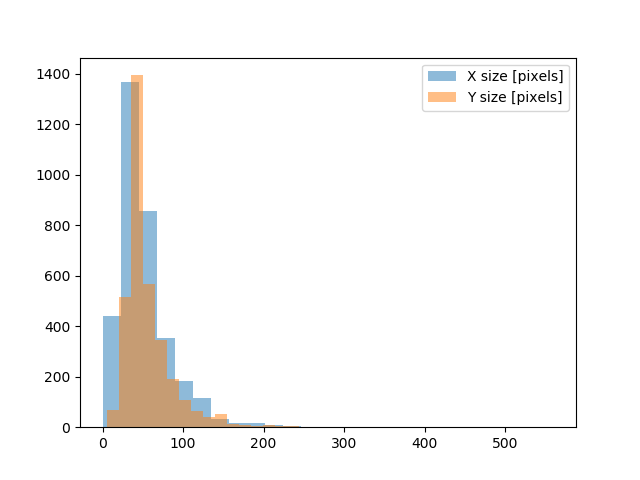

In [19]:
plt.figure()
plt.hist(sizes[:,1], bins=25, alpha=0.5, label='X size [pixels]')
plt.hist(sizes[:,2], bins=25, alpha=0.5, label='Y size [pixels]')
plt.legend()

In [26]:
sizes[4]

array([288,  49,  56])

In [37]:
import sys

In [39]:
sys.getsizeof(np.ones_like(sizes[0]))

120

In [51]:
cubes

['/group/askap/mcc381/RACS/8585/RACS_test4_1.05_1049-31A/image.restored.q.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits',
 '/group/askap/mcc381/RACS/8585/RACS_test4_1.05_1049-31A/image.restored.u.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits',
 '/group/askap/mcc381/RACS/8585/RACS_test4_1.05_1049-31A/image.restored.i.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits']

Size in GB:  114.73631769599997


In [58]:
q_cube[0,:,:].nbytes*288*1e-6/1000

87.58619136

In [60]:
from fs.memoryfs import MemoryFS

In [16]:
%%time
i_cutouts[100].hdulist

CPU times: user 108 ms, sys: 484 ms, total: 592 ms
Wall time: 36.4 s


In [67]:
mem_fs = MemoryFS()
mem_fs.makedirs('cutouts')
    #i_cutouts[0].write(apple, format='fits', overwrite=True)

SubFS(MemoryFS(), '/cutouts')

In [70]:
for i in tnrange(len(i_cutouts)):
    with mem_fs.open('cutouts/'+'image.restored.i.SB' + sbid[:-1] + '.contcube.'+field[:-1]+'.cutout.'+\
            source_dict['name'][i]+'.fits', 'wb') as fitsfile:
        i_cutouts[i].write(fitsfile, overwrite=True, format='fits')

KeyboardInterrupt: 

In [69]:
for path in mem_fs.walk.files():
    print(path)
#mem.close()

In [42]:
i_cutouts[0].hdulist.writeto()

TypeError: writeto() missing 1 required positional argument: 'fileobj'

In [17]:
outdir = rootdir+sbid+field+'cutouts/'
try:
    os.mkdir(outdir)
except:
    print('Directory exists')

Directory exists


In [ ]:
print(outdir)

In [ ]:
outdir = '/home/athomson/cutouts/'
try:
    os.mkdir(outdir)
except:
    print('Dir exists')

In [ ]:
import os
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')  # e.g. 4015976448
mem_gib = mem_bytes/(1024.**3)  # e.g. 3.74
print(mem_gib)

In [18]:
for i in tnrange(10):
    outfile = outdir + 'image.restored.i.SB' + sbid[:-1] + '.contcube.'+field[:-1]+'.cutout.'+\
            source_dict['name'][i]+'.fits'
    i_cutouts[i].write(outfile, format='fits', overwrite=True)

KeyboardInterrupt: 

In [ ]:
%%time
for i in tnrange(0,100):
    with mem_fs.open('cutouts/'+'image.restored.i.SB' + sbid[:-1] + '.contcube.'+field[:-1]+'.cutout.'+\
            source_dict['name'][i]+'.fits', 'wb') as fitsfile:
        fits.writeto(fitsfile, i_cutouts[i], i_cutouts[i].header, overwrite=True)

In [ ]:
for i in tqdm(range(len(i_cutouts))):
    outfile = outdir + 'image.restored.i.SB' + sbid[:-1] + '.contcube.'+field[:-1]+'.cutout.'+\
            source_dict['name'][i]+'.fits'
    i_cutouts[i].write(outfile, format='fits', overwrite=True)
    #outfile = outdir + 'image.restored.q.SB' + sbid[:-1] + '.contcube.'+field[:-1]+'.cutout.'+\
    #        source_dict['name'][i]+'.fits'
    #q_cutouts[i].write(outfile, format='fits', overwrite=True)
   # 
   # outfile = outdir + 'image.restored.u.SB' + sbid[:-1] + '.contcube.'+field[:-1]+'.cutout.'+\
    #        source_dict['name'][i]+'.fits'
    #u_cutouts[i].write(outfile, format='fits', overwrite=True)

In [ ]:
nplots  = 12
fig, axes = plt.subplots(nplots//4, 4, constrained_layout=True)
for ax, cutout in tqdm_notebook(zip(axes.flatten(), i_cutouts), total=nplots):
        ax.imshow(np.array(cutout.moment0(axis=0)), origin='lower')

        
fig, axes = plt.subplots(nplots//4, 4, constrained_layout=True)
for ax, q_cutout, u_cutout in tqdm_notebook(zip(axes.flatten(), q_cutouts, u_cutouts), total=nplots):
        ax.imshow(np.sum(np.hypot(np.array(q_cutout), np.array(u_cutout)), axis=0), origin='lower', cmap=plt.cm.coolwarm)



In [ ]:
#%%bash
#head selavy-SubimageLocations.ann#
#locations = pd.read_fwf('selavy-SubimageLocations.ann', skiprows=3, names=['type','ra1', 'dec1','ra2','dec2'])
#text_locs = list(locations[locations.type=='TEXT'].index)
#for low, high in zip([-1]+text_locs,text_locs):
#    print(locations.loc[low+1:high-1])
#locations.groupby('type', sort=False)
#for g in locations.groupby('type', sort=False):
#    print(g)
#    break

In [76]:
source_dict

{'island_id': ['SB8583_RACS_test4_1.05_1049-31A_island_1',
  'SB8583_RACS_test4_1.05_1049-31A_island_1',
  'SB8583_RACS_test4_1.05_1049-31A_island_10',
  'SB8583_RACS_test4_1.05_1049-31A_island_1001',
  'SB8583_RACS_test4_1.05_1049-31A_island_1002',
  'SB8583_RACS_test4_1.05_1049-31A_island_1003',
  'SB8583_RACS_test4_1.05_1049-31A_island_1006',
  'SB8583_RACS_test4_1.05_1049-31A_island_1009',
  'SB8583_RACS_test4_1.05_1049-31A_island_101',
  'SB8583_RACS_test4_1.05_1049-31A_island_1011',
  'SB8583_RACS_test4_1.05_1049-31A_island_1012',
  'SB8583_RACS_test4_1.05_1049-31A_island_1013',
  'SB8583_RACS_test4_1.05_1049-31A_island_1014',
  'SB8583_RACS_test4_1.05_1049-31A_island_1015',
  'SB8583_RACS_test4_1.05_1049-31A_island_1016',
  'SB8583_RACS_test4_1.05_1049-31A_island_1017',
  'SB8583_RACS_test4_1.05_1049-31A_island_1018',
  'SB8583_RACS_test4_1.05_1049-31A_island_1019',
  'SB8583_RACS_test4_1.05_1049-31A_island_1024',
  'SB8583_RACS_test4_1.05_1049-31A_island_1029',
  'SB8583_RACS_t

island_id
|S44
island_name
|S15
n_components
int32
ra_hms_cont
|S11
dec_dms_cont
|S10
ra_deg_cont
float64
dec_deg_cont
float64
freq
float32
maj_axis
float32
min_axis
float32
pos_ang
float32
flux_int
float32
flux_int_err
float32
flux_peak
float32
mean_background
float32
background_noise
float32
max_residual
float32
min_residual
float32
mean_residual
float32
rms_residual
float32
stdev_residual
float32
x_min
int32
x_max
int32
y_min
int32
y_max
int32
n_pix
int32
solid_angle
float32
beam_area
float32
x_ave
float32
y_ave
float32
x_cen
float32
y_cen
float32
x_peak
int32
y_peak
int32
flag_i1
int32
flag_i2
int32
flag_i3
int32
flag_i4
int32
comment
|S100


In [52]:
class FitsWrapper:
    def __init__(self, cube):
        self.h = cube.header
        
        self.data = {}
        for i, c in enumerate(self.h.__dict__['_cards']):
            if c[0] == '': continue
                
            # Append to existing cards
            if self.data.get(c[0], None) is None:
                self.data[c[0]] = c[1]
            else:
                self.data[c[0]] = self.data[c[0]] + ' ' + c[1]
            
        #if self.data.get('FILENAME', None) is None:
        #    self.data['FILENAME'] = os.path.basename(fits_filename)

    def to_json(self):
        return json.dumps(self.data, default=lambda x: x.__dict__, indent=4)
        
    def load_mongodb(self, collection, verbose=False):
        json_data = json.loads(self.to_json())
        
        # This uses replace_one to replace any existing document that matches the filter. 
        # If none is matched, upsert=True creates a new document.
        result = collection.replace_one(filter={'FILENAME': self.data['FILENAME']}, replacement=json_data, upsert=True)
        
        if verbose:
            print('Modified: ', result.modified_count)
            print('Insert ID: ', result.upserted_id)

In [60]:
FitsWrapper(i_cutouts[0]).load_mongodb(cublet_db)

KeyError: 'FILENAME'

In [9]:
from dataclasses import dataclass, field, asdict
from astropy.coordinates import SkyCoord
import astropy.units as u
import json

@dataclass
class Stokes:
    stokes: str
        
@dataclass
class Coords:
    ra: float
    dec: float

@dataclass
class Cubelet:
    name: str
    coords: Coords
    idata: str
    qdata: str
    udata: str

    
    def to_json(self):
        return json.dumps(self.__dict__, default=lambda x: x.__dict__, indent=4)

In [10]:
c = Coords(ra=source_dict['ra_deg_cont'][0], dec=source_dict['dec_deg_cont'][0])

In [11]:
cbe = Cubelet(name=source_dict['island_name'][0], 
              coords=c,
              idata=source_dict['i_file'][0], 
              qdata=source_dict['q_file'][0], 
              udata=source_dict['u_file'][0])

In [12]:
print(cbe.to_json())

{
    "name": "J103313-341845",
    "coords": {
        "ra": 158.304112,
        "dec": -34.312559
    },
    "idata": "/group/askap/mcc381/RACS/8585/RACS_test4_1.05_1049-31A/cutouts/image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103313-341845.fits",
    "qdata": "/group/askap/mcc381/RACS/8585/RACS_test4_1.05_1049-31A/cutouts/image.restored.q.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103313-341845.fits",
    "udata": "/group/askap/mcc381/RACS/8585/RACS_test4_1.05_1049-31A/cutouts/image.restored.u.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103313-341845.fits"
}


In [13]:
import pymongo
client = pymongo.MongoClient()  # default connection (ie, local)

In [14]:
db_name = 'test'
db = client[db_name]  # database
cublet_db = db.cubelets  # collection; can also call as db['dwarfs']
#cublet_db.drop()

In [15]:
cublet_db.drop()

In [16]:
json_data = json.loads(cbe.to_json())
result = cublet_db.insert_one(json_data)

In [17]:
# Quick check to confirm load
cursor = cublet_db.find({'name': 'J103313-341845'})
for doc in cursor:
    print(doc)

{'_id': ObjectId('5d847e9d132fcb7b83c8543d'), 'name': 'J103313-341845', 'coords': {'ra': 158.304112, 'dec': -34.312559}, 'idata': '/group/askap/mcc381/RACS/8585/RACS_test4_1.05_1049-31A/cutouts/image.restored.i.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103313-341845.fits', 'qdata': '/group/askap/mcc381/RACS/8585/RACS_test4_1.05_1049-31A/cutouts/image.restored.q.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103313-341845.fits', 'udata': '/group/askap/mcc381/RACS/8585/RACS_test4_1.05_1049-31A/cutouts/image.restored.u.SB8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103313-341845.fits'}


In [18]:
data = []
for i in tnrange(len(i_cutouts)):
    c = Coords(ra=source_dict['ra_deg_cont'][i], dec=source_dict['dec_deg_cont'][i])
    cbe = Cubelet(name=source_dict['island_name'][i], 
                  coords=c,
                  idata=source_dict['i_file'][i], 
                  qdata=source_dict['q_file'][i], 
                  udata=source_dict['u_file'][i])
    data.append(cbe)

In [19]:
for row in tqdm_notebook(data):
    name = row.name
    json_data = json.loads(row.to_json())
    
    count = cublet_db.count_documents({'name': name})

    if count > 0:
        # Replace existing
        cursor = cublet_db.find({'name': name})
        for doc in cursor:
            result = cublet_db.replace_one({'_id': doc['_id']}, json_data)
    else:
        # Insert new
        result = cublet_db.insert_one(json_data)

In [20]:
count = cublet_db.count_documents({})
print('Total documents: ', count)

Total documents:  3399


In [29]:
cursor = cublet_db.find({'coords': {"ra": {"gt": 5}}})
for doc in cursor:
    print(doc)

In [33]:
cursor = cublet_db.find({'coords.loc': {'$exists': False}})
for doc in cursor:
    geojson = { 'type': "Point", 'coordinates': [ doc['coords']['ra']-180., doc['coords']['dec'] ] }
    print(doc['name'], doc['coords']['ra'], doc['coords']['dec'], geojson)
    cublet_db.update_one({'_id': doc['_id']}, {'$set': {'coords.loc': geojson}})

J103313-341845 158.304112 -34.312559 {'type': 'Point', 'coordinates': [-21.695887999999997, -34.312559]}
J110106-314027 165.278278 -31.674425 {'type': 'Point', 'coordinates': [-14.721722, -31.674425]}
J105404-302031 163.517176 -30.342017 {'type': 'Point', 'coordinates': [-16.482823999999994, -30.342017]}
J110142-333425 165.426516 -33.573747 {'type': 'Point', 'coordinates': [-14.573484000000008, -33.573747]}
J103831-304818 159.63009 -30.805173 {'type': 'Point', 'coordinates': [-20.369910000000004, -30.805173]}
J104642-285804 161.675101 -28.967938 {'type': 'Point', 'coordinates': [-18.324898999999988, -28.967938]}
J110043-310730 165.181259 -31.125052 {'type': 'Point', 'coordinates': [-14.818740999999989, -31.125052]}
J105754-284635 164.475423 -28.776474 {'type': 'Point', 'coordinates': [-15.524576999999994, -28.776474]}
J105718-341727 164.325304 -34.290986 {'type': 'Point', 'coordinates': [-15.674696000000012, -34.290986]}
J104633-324900 161.640608 -32.816445 {'type': 'Point', 'coordinat

J105325-323901 163.354386 -32.650351 {'type': 'Point', 'coordinates': [-16.645613999999995, -32.650351]}
J104145-290102 160.43972 -29.017252 {'type': 'Point', 'coordinates': [-19.560280000000006, -29.017252]}
J105442-312426 163.67558 -31.407321 {'type': 'Point', 'coordinates': [-16.324420000000003, -31.407321]}
J104938-322842 162.411478 -32.478389 {'type': 'Point', 'coordinates': [-17.58852200000001, -32.478389]}
J104120-285855 160.333386 -28.98214 {'type': 'Point', 'coordinates': [-19.66661400000001, -28.98214]}
J105801-300902 164.507339 -30.150737 {'type': 'Point', 'coordinates': [-15.492660999999998, -30.150737]}
J103849-285534 159.705295 -28.926342 {'type': 'Point', 'coordinates': [-20.294704999999993, -28.926342]}
J103903-323039 159.764946 -32.510835 {'type': 'Point', 'coordinates': [-20.23505399999999, -32.510835]}
J105542-293455 163.925404 -29.58214 {'type': 'Point', 'coordinates': [-16.074596000000014, -29.58214]}
J104901-321853 162.256515 -32.314768 {'type': 'Point', 'coordina

J104031-323510 160.131788 -32.586154 {'type': 'Point', 'coordinates': [-19.868212, -32.586154]}
J104050-303518 160.208656 -30.588398 {'type': 'Point', 'coordinates': [-19.79134400000001, -30.588398]}
J104951-290436 162.464872 -29.076897 {'type': 'Point', 'coordinates': [-17.535127999999986, -29.076897]}
J110104-314030 165.268171 -31.675174 {'type': 'Point', 'coordinates': [-14.731829000000005, -31.675174]}
J104252-335004 160.718149 -33.834522 {'type': 'Point', 'coordinates': [-19.28185099999999, -33.834522]}
J105045-321249 162.691 -32.21376 {'type': 'Point', 'coordinates': [-17.308999999999997, -32.21376]}
J104953-334656 162.472731 -33.78226 {'type': 'Point', 'coordinates': [-17.52726899999999, -33.78226]}
J104106-334811 160.278062 -33.803131 {'type': 'Point', 'coordinates': [-19.721937999999994, -33.803131]}
J103655-295716 159.232122 -29.95463 {'type': 'Point', 'coordinates': [-20.767877999999996, -29.95463]}
J105734-321316 164.39344 -32.221343 {'type': 'Point', 'coordinates': [-15.60

J104706-330533 161.778194 -33.092562 {'type': 'Point', 'coordinates': [-18.221805999999987, -33.092562]}
J103900-292235 159.750947 -29.37661 {'type': 'Point', 'coordinates': [-20.249053000000004, -29.37661]}
J103715-332546 159.313472 -33.429652 {'type': 'Point', 'coordinates': [-20.68652800000001, -33.429652]}
J110318-335019 165.827179 -33.838654 {'type': 'Point', 'coordinates': [-14.172820999999999, -33.838654]}
J105910-292256 164.79554 -29.382404 {'type': 'Point', 'coordinates': [-15.204460000000012, -29.382404]}
J103857-303528 159.739127 -30.591294 {'type': 'Point', 'coordinates': [-20.260873000000004, -30.591294]}
J105505-294557 163.77085 -29.766082 {'type': 'Point', 'coordinates': [-16.229150000000004, -29.766082]}
J103735-320000 159.399715 -32.0001 {'type': 'Point', 'coordinates': [-20.600285000000014, -32.0001]}
J110231-295339 165.632495 -29.89422 {'type': 'Point', 'coordinates': [-14.367504999999994, -29.89422]}
J104444-330153 161.184708 -33.031526 {'type': 'Point', 'coordinate

J103916-284249 159.820231 -28.713692 {'type': 'Point', 'coordinates': [-20.179768999999993, -28.713692]}
J104525-303956 161.355638 -30.665575 {'type': 'Point', 'coordinates': [-18.644362, -30.665575]}
J110206-302916 165.526553 -30.487819 {'type': 'Point', 'coordinates': [-14.473446999999993, -30.487819]}
J104200-304603 160.501424 -30.767754 {'type': 'Point', 'coordinates': [-19.498576000000014, -30.767754]}
J104836-305703 162.15372 -30.951072 {'type': 'Point', 'coordinates': [-17.846280000000007, -30.951072]}
J103624-284406 159.100522 -28.735094 {'type': 'Point', 'coordinates': [-20.899477999999988, -28.735094]}
J110022-292300 165.094854 -29.383561 {'type': 'Point', 'coordinates': [-14.905146000000002, -29.383561]}
J105305-332021 163.272298 -33.339196 {'type': 'Point', 'coordinates': [-16.727701999999994, -33.339196]}
J103614-311431 159.059027 -31.242014 {'type': 'Point', 'coordinates': [-20.940973000000014, -31.242014]}
J103901-322856 159.757381 -32.482299 {'type': 'Point', 'coordinat

J104723-292740 161.847568 -29.461389 {'type': 'Point', 'coordinates': [-18.152432000000005, -29.461389]}
J105421-311333 163.589042 -31.225859 {'type': 'Point', 'coordinates': [-16.410957999999994, -31.225859]}
J104247-305737 160.699516 -30.960462 {'type': 'Point', 'coordinates': [-19.30048400000001, -30.960462]}
J103918-305012 159.825431 -30.836825 {'type': 'Point', 'coordinates': [-20.17456899999999, -30.836825]}
J103731-333002 159.380797 -33.500562 {'type': 'Point', 'coordinates': [-20.619203, -33.500562]}
J105332-285525 163.38437 -28.923828 {'type': 'Point', 'coordinates': [-16.61563000000001, -28.923828]}
J103900-300845 159.753803 -30.145945 {'type': 'Point', 'coordinates': [-20.246196999999995, -30.145945]}
J103457-335401 158.73854 -33.900525 {'type': 'Point', 'coordinates': [-21.26146, -33.900525]}
J105944-292541 164.934573 -29.428283 {'type': 'Point', 'coordinates': [-15.065427, -29.428283]}
J103905-333625 159.771235 -33.607087 {'type': 'Point', 'coordinates': [-20.2287650000000

J110102-283706 165.259408 -28.618376 {'type': 'Point', 'coordinates': [-14.740591999999992, -28.618376]}
J103631-342145 159.129484 -34.362656 {'type': 'Point', 'coordinates': [-20.87051600000001, -34.362656]}
J104200-284832 160.500959 -28.809012 {'type': 'Point', 'coordinates': [-19.499041000000005, -28.809012]}
J105639-314650 164.1659 -31.780736 {'type': 'Point', 'coordinates': [-15.834100000000007, -31.780736]}
J105436-310108 163.650025 -31.01895 {'type': 'Point', 'coordinates': [-16.349975, -31.01895]}
J104622-310950 161.591512 -31.164117 {'type': 'Point', 'coordinates': [-18.408488000000006, -31.164117]}
J103747-323606 159.447018 -32.601794 {'type': 'Point', 'coordinates': [-20.552981999999986, -32.601794]}
J105132-303912 162.884033 -30.653555 {'type': 'Point', 'coordinates': [-17.115967000000012, -30.653555]}
J104010-284830 160.043671 -28.808471 {'type': 'Point', 'coordinates': [-19.95632900000001, -28.808471]}
J104617-282853 161.572183 -28.481434 {'type': 'Point', 'coordinates': 

J105321-315313 163.338389 -31.887057 {'type': 'Point', 'coordinates': [-16.661610999999994, -31.887057]}
J110247-302855 165.699355 -30.48213 {'type': 'Point', 'coordinates': [-14.300645000000003, -30.48213]}
J104949-331644 162.455534 -33.278978 {'type': 'Point', 'coordinates': [-17.544466, -33.278978]}
J104912-324729 162.303312 -32.791578 {'type': 'Point', 'coordinates': [-17.696687999999995, -32.791578]}
J103855-323421 159.73083 -32.572587 {'type': 'Point', 'coordinates': [-20.269170000000003, -32.572587]}
J105733-324427 164.387762 -32.740886 {'type': 'Point', 'coordinates': [-15.61223799999999, -32.740886]}
J105818-284612 164.575151 -28.770029 {'type': 'Point', 'coordinates': [-15.424848999999995, -28.770029]}
J105032-320743 162.635071 -32.128697 {'type': 'Point', 'coordinates': [-17.36492899999999, -32.128697]}
J105730-283633 164.378376 -28.609323 {'type': 'Point', 'coordinates': [-15.621623999999997, -28.609323]}
J105023-325209 162.597942 -32.869339 {'type': 'Point', 'coordinates':

J110303-323121 165.765499 -32.522709 {'type': 'Point', 'coordinates': [-14.234500999999995, -32.522709]}
J110023-315152 165.097938 -31.864469 {'type': 'Point', 'coordinates': [-14.902062, -31.864469]}
J105846-330747 164.694382 -33.129978 {'type': 'Point', 'coordinates': [-15.30561800000001, -33.129978]}
J104730-305244 161.875501 -30.879045 {'type': 'Point', 'coordinates': [-18.124498999999986, -30.879045]}
J105058-295057 162.743037 -29.849398 {'type': 'Point', 'coordinates': [-17.256963000000013, -29.849398]}
J104106-304020 160.278253 -30.67244 {'type': 'Point', 'coordinates': [-19.721746999999993, -30.67244]}
J104650-324748 161.712039 -32.796763 {'type': 'Point', 'coordinates': [-18.287960999999996, -32.796763]}
J104616-295218 161.569146 -29.871771 {'type': 'Point', 'coordinates': [-18.43085400000001, -29.871771]}
J105245-285037 163.188968 -28.843769 {'type': 'Point', 'coordinates': [-16.81103200000001, -28.843769]}
J103730-315453 159.37801 -31.914948 {'type': 'Point', 'coordinates': 

J103946-300125 159.942886 -30.023621 {'type': 'Point', 'coordinates': [-20.057114000000013, -30.023621]}
J104014-313618 160.0587 -31.605083 {'type': 'Point', 'coordinates': [-19.941300000000012, -31.605083]}
J104205-323505 160.524328 -32.584889 {'type': 'Point', 'coordinates': [-19.475672000000003, -32.584889]}
J105041-330226 162.674259 -33.040579 {'type': 'Point', 'coordinates': [-17.325740999999994, -33.040579]}
J110036-305714 165.151197 -30.954068 {'type': 'Point', 'coordinates': [-14.848803000000004, -30.954068]}
J105902-322101 164.760822 -32.350421 {'type': 'Point', 'coordinates': [-15.23917800000001, -32.350421]}
J105550-293234 163.959367 -29.542996 {'type': 'Point', 'coordinates': [-16.040633000000014, -29.542996]}
J105849-320354 164.707085 -32.065252 {'type': 'Point', 'coordinates': [-15.292914999999994, -32.065252]}
J105406-305218 163.52589 -30.871861 {'type': 'Point', 'coordinates': [-16.474109999999996, -30.871861]}
J104426-312748 161.110476 -31.463575 {'type': 'Point', 'coo

J104625-320641 161.606365 -32.111593 {'type': 'Point', 'coordinates': [-18.39363499999999, -32.111593]}
J104913-300221 162.307569 -30.039252 {'type': 'Point', 'coordinates': [-17.692431, -30.039252]}
J104839-320228 162.163313 -32.041278 {'type': 'Point', 'coordinates': [-17.836687000000012, -32.041278]}
J105242-304012 163.178122 -30.670251 {'type': 'Point', 'coordinates': [-16.821877999999998, -30.670251]}
J104712-325548 161.801612 -32.930105 {'type': 'Point', 'coordinates': [-18.198387999999994, -32.930105]}
J104337-320600 160.906009 -32.099762 {'type': 'Point', 'coordinates': [-19.09399099999999, -32.099762]}
J105735-301038 164.397944 -30.177357 {'type': 'Point', 'coordinates': [-15.602056000000005, -30.177357]}
J105159-302340 162.998288 -30.39471 {'type': 'Point', 'coordinates': [-17.001711999999998, -30.39471]}
J105358-323009 163.491983 -32.502588 {'type': 'Point', 'coordinates': [-16.508016999999995, -32.502588]}
J104601-322654 161.506296 -32.448606 {'type': 'Point', 'coordinates'

J104917-292924 162.321228 -29.490231 {'type': 'Point', 'coordinates': [-17.67877200000001, -29.490231]}
J105840-335204 164.669287 -33.867824 {'type': 'Point', 'coordinates': [-15.330713000000003, -33.867824]}
J105349-283918 163.457521 -28.655077 {'type': 'Point', 'coordinates': [-16.542478999999986, -28.655077]}
J105338-335402 163.411043 -33.900769 {'type': 'Point', 'coordinates': [-16.588956999999994, -33.900769]}
J105010-303046 162.545073 -30.512871 {'type': 'Point', 'coordinates': [-17.454926999999998, -30.512871]}
J103925-334311 159.856902 -33.719983 {'type': 'Point', 'coordinates': [-20.14309800000001, -33.719983]}
J110027-292253 165.113697 -29.381536 {'type': 'Point', 'coordinates': [-14.886302999999998, -29.381536]}
J104807-313226 162.030475 -31.540757 {'type': 'Point', 'coordinates': [-17.969525000000004, -31.540757]}
J105317-335007 163.321949 -33.835532 {'type': 'Point', 'coordinates': [-16.67805100000001, -33.835532]}
J104131-302825 160.381269 -30.473801 {'type': 'Point', 'co

In [34]:
if 'geosphere' not in cublet_db.index_information():
    cublet_db.create_index([('coords.loc', pymongo.GEOSPHERE)],
                          name='geosphere', background=True)

In [35]:
def wgs_scale(lat):
    # Get scaling to convert degrees to meters at a given geodetic latitude (declination)
    
    # Values from WGS 84
    a = 6378137.000000000000 # Semi-major axis of Earth
    b = 6356752.314140000000 # Semi-minor axis of Earth
    e = 0.081819190842600 # eccentricity
    angle = np.radians(1.0)
    
    # Compute radius of curvature along meridian (see https://en.wikipedia.org/wiki/Meridian_arc)
    rm = a * (1 - np.power(e, 2)) / np.power( ( (1 - np.power(e, 2) * np.power( np.sin(np.radians(lat)), 2) ) ), 1.5)
    
    # Compute length of arc at this latitude (meters/degree)
    arc = rm * angle
    return arc

In [41]:
ra, dec = 220., 12.
lon, lat = ra-180., dec
radius = 10 # degrees
radius *= wgs_scale(lat) # meters
print(lon, lat, radius)

# Perform the search
cursor = cublet_db.find({'coords.loc': {
    '$nearSphere': { 
        '$geometry': { 'type': 'Point', 
                      'coordinates': [lon, lat]}, 
        '$maxDistance': radius
    } } })
for doc in cursor:
    print(doc['name'], doc['coords']['ra'], doc['coords']['dec'], doc['coords']['loc'])

40.0 12.0 1106222.9012842258


In [42]:
def cone_search(ra, dec, radius, collection=cublet_db, field='coords.loc'):
    
    scaling = wgs_scale(dec)
    meter_radius = radius * scaling
    lon, lat = ra-180., dec
    
    cursor = collection.find({'coords.loc': {
    '$nearSphere': { 
        '$geometry': { 'type': 'Point', 
                      'coordinates': [lon, lat]}, 
        '$maxDistance': meter_radius
    } } })
    
    return cursor

In [46]:
# Use the function
cursor = cone_search(220., 12., 180.)
for doc in cursor:
    print(doc['name'], doc['coords']['ra'], doc['coords']['dec'], doc['coords']['loc'])

J110251-282242 165.713423 -28.378365 {'type': 'Point', 'coordinates': [-14.286576999999994, -28.378365]}
J110308-283304 165.784106 -28.551248 {'type': 'Point', 'coordinates': [-14.215893999999992, -28.551248]}
J110300-283435 165.751888 -28.576401 {'type': 'Point', 'coordinates': [-14.248111999999992, -28.576401]}
J110232-282629 165.63645 -28.441567 {'type': 'Point', 'coordinates': [-14.363550000000004, -28.441567]}
J110228-282718 165.617732 -28.455249 {'type': 'Point', 'coordinates': [-14.38226800000001, -28.455249]}
J110209-282316 165.538643 -28.388007 {'type': 'Point', 'coordinates': [-14.461356999999992, -28.388007]}
J110200-282131 165.500846 -28.358651 {'type': 'Point', 'coordinates': [-14.499154000000004, -28.358651]}
J110226-283238 165.609788 -28.544044 {'type': 'Point', 'coordinates': [-14.390211999999991, -28.544044]}
J110212-282847 165.553508 -28.479939 {'type': 'Point', 'coordinates': [-14.446492000000006, -28.479939]}
J110138-282121 165.412285 -28.356073 {'type': 'Point', 'c

J110202-321307 165.511466 -32.218669 {'type': 'Point', 'coordinates': [-14.488533999999987, -32.218669]}
J110322-324102 165.843049 -32.684021 {'type': 'Point', 'coordinates': [-14.156950999999992, -32.684021]}
J105700-302231 164.249677 -30.37541 {'type': 'Point', 'coordinates': [-15.750323000000009, -30.37541]}
J105159-282325 162.999136 -28.390323 {'type': 'Point', 'coordinates': [-17.000864000000007, -28.390323]}
J110049-314715 165.204176 -31.787554 {'type': 'Point', 'coordinates': [-14.79582400000001, -31.787554]}
J105807-304840 164.529631 -30.811367 {'type': 'Point', 'coordinates': [-15.470369000000005, -30.811367]}
J105534-295122 163.89367 -29.856174 {'type': 'Point', 'coordinates': [-16.106330000000014, -29.856174]}
J105549-295704 163.95473 -29.951335 {'type': 'Point', 'coordinates': [-16.045269999999988, -29.951335]}
J110058-315224 165.242471 -31.873498 {'type': 'Point', 'coordinates': [-14.757529000000005, -31.873498]}
J105300-285025 163.249981 -28.840439 {'type': 'Point', 'coor

J105207-312847 163.029102 -31.479765 {'type': 'Point', 'coordinates': [-16.970898000000005, -31.479765]}
J104810-295524 162.042911 -29.923519 {'type': 'Point', 'coordinates': [-17.957088999999996, -29.923519]}
J105139-311843 162.915783 -31.311959 {'type': 'Point', 'coordinates': [-17.084216999999995, -31.311959]}
J105143-312008 162.931013 -31.335593 {'type': 'Point', 'coordinates': [-17.068986999999993, -31.335593]}
J105627-330558 164.116297 -33.099535 {'type': 'Point', 'coordinates': [-15.883702999999997, -33.099535]}
J104710-293053 161.793204 -29.514743 {'type': 'Point', 'coordinates': [-18.206795999999997, -29.514743]}
J105625-330541 164.105206 -33.094728 {'type': 'Point', 'coordinates': [-15.89479399999999, -33.094728]}
J104925-302653 162.356447 -30.448093 {'type': 'Point', 'coordinates': [-17.643552999999997, -30.448093]}
J105211-313200 163.048134 -31.533405 {'type': 'Point', 'coordinates': [-16.951865999999995, -31.533405]}
J104515-284321 161.314909 -28.722513 {'type': 'Point', '

J103745-282228 159.439069 -28.374697 {'type': 'Point', 'coordinates': [-20.56093100000001, -28.374697]}
J104639-320827 161.665247 -32.140911 {'type': 'Point', 'coordinates': [-18.334753000000006, -32.140911]}
J103848-285138 159.702441 -28.860682 {'type': 'Point', 'coordinates': [-20.297559000000007, -28.860682]}
J104538-314448 161.410376 -31.746727 {'type': 'Point', 'coordinates': [-18.589623999999986, -31.746727]}
J104306-304254 160.776187 -30.715126 {'type': 'Point', 'coordinates': [-19.223813000000007, -30.715126]}
J104941-331901 162.424748 -33.317102 {'type': 'Point', 'coordinates': [-17.575252000000006, -33.317102]}
J104132-300327 160.384128 -30.057734 {'type': 'Point', 'coordinates': [-19.615871999999996, -30.057734]}
J104508-313306 161.2846 -31.55173 {'type': 'Point', 'coordinates': [-18.71539999999999, -31.55173]}
J104526-314037 161.361761 -31.677017 {'type': 'Point', 'coordinates': [-18.638239, -31.677017]}
J104930-331514 162.378339 -33.254001 {'type': 'Point', 'coordinates': 

J104102-342337 160.259933 -34.393828 {'type': 'Point', 'coordinates': [-19.74006700000001, -34.393828]}
J103550-321810 158.960398 -32.302965 {'type': 'Point', 'coordinates': [-21.039602000000002, -32.302965]}
J103842-332858 159.67587 -33.482961 {'type': 'Point', 'coordinates': [-20.324129999999997, -33.482961]}
J104037-341520 160.157654 -34.255778 {'type': 'Point', 'coordinates': [-19.842345999999992, -34.255778]}
J103640-324020 159.169622 -32.672421 {'type': 'Point', 'coordinates': [-20.830377999999996, -32.672421]}
J103552-322051 158.966468 -32.347501 {'type': 'Point', 'coordinates': [-21.033532000000008, -32.347501]}
J103617-323234 159.073685 -32.542844 {'type': 'Point', 'coordinates': [-20.92631499999999, -32.542844]}
J103550-322112 158.960085 -32.353481 {'type': 'Point', 'coordinates': [-21.039915000000008, -32.353481]}
J103730-330334 159.378612 -33.059512 {'type': 'Point', 'coordinates': [-20.621387999999996, -33.059512]}
J103938-335510 159.91038 -33.91965 {'type': 'Point', 'coor